# Simple FNN & MLP

`Author: YUAN Yanzhe`

- realized a simple baseline of MLP in MNIST calssification task using PyTorch
  - the network structure is: input-linear-relu-linear-softmax
  
- for reference in the future work

## MLP in MNIST


- notes
  - 有三个关于矩阵乘法的函数：
    - torch.mm：矩阵乘法 mat*mat
    - torch.matmul：张量乘法 tensor*tensor
    - torch.bmm：两个batch矩阵乘法 (batch,n,m)*(batch,m,p)
  - 降低泛化误差
    - 模型选择
      - 候选模型可以是有不同超参数的模型，比如MLP的隐层个数，隐层神经元个数，激活函数等都可以是超参数。
      - 通过dev或者validation set来选择模型
      - 当数据量有限时，通过K折交叉验证来选择模型，充分利用数据
    - 过拟合&欠拟合: bias & variance tradeoff
      - 解决方法
        - 权重衰减weight decay
          - 权重衰减可以通过优化器中的weight_decay超参数来指定。
        - 丢弃法dropout
          - 只在训练的时候运用
          - nn.Dropout(prob)
  - 数值稳定性以及模型初始化
     - 深度模型有关数值稳定性的典型问题是衰减和爆炸.
     - PyTorch中nn.Module的模块参数都采取了较为合理的初始化策略.

In [7]:
# import packages
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import init 
import torchvision
from torch.utils import data as Data
from torchvision import transforms

import numpy 
import matplotlib 
from matplotlib import pyplot as plt

import d2lzh_pytorch as d2dl


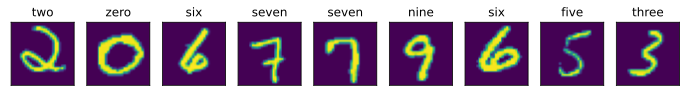

mlp(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)
Epoch: 1, avg_loss: 2.2647, avg_acc: 0.300733
Epoch: 1, test_acc:0.5114
Epoch: 2, avg_loss: 2.0401, avg_acc: 0.600217
Epoch: 2, test_acc:0.6784
Epoch: 3, avg_loss: 1.4889, avg_acc: 0.711150
Epoch: 3, test_acc:0.7590
Epoch: 4, avg_loss: 1.0132, avg_acc: 0.783117
Epoch: 4, test_acc:0.8135
Epoch: 5, avg_loss: 0.7708, avg_acc: 0.823050
Epoch: 5, test_acc:0.8419


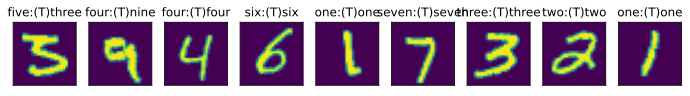

In [24]:
# Hyperparameters
num_input = 784
num_hidden = 256
num_output = 10

batch_size = 256
num_epochs = 5
learning_rate = 0.01

# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',\
                                       train=True, transform=transforms.ToTensor()) 

test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',\
                                       train=False, transform=transforms.ToTensor())

# Load Data
train_iterator = Data.DataLoader(train_data,batch_size,shuffle=True)
test_iterator = Data.DataLoader(test_data,batch_size,shuffle=True)

# Visualize Data
def labels_to_text(labels):
    dictionary = ['zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine']
    return [dictionary[int(i)] for i in labels]

def draw_multiple_images(images, labels):
    d2dl.use_svg_display()
    _, axes = plt.subplots(1, len(labels), figsize=(12,12))
    for axe,image,label in zip(axes, images, labels):
        axe.imshow(image.view(image.size(1),image.size(1),-1))
        axe.set_title(label)
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
    plt.show()

# draw
exmp, lbl = iter(train_iterator).next()
draw_multiple_images(exmp[0:9],labels_to_text(lbl[0:9]))

# Define Model
class mlp(nn.Module):
    def __init__(self,num_input,num_hidden,num_output):
        super(mlp,self).__init__()
        self.linear_1 = nn.Linear(num_input,num_hidden)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(num_hidden,num_output)
    
    def forward(self, x):
        y = self.linear_2(self.relu(self.linear_1(x)))
        return y

net = mlp(num_input,num_hidden,num_output)
print(net)

loss_func = nn.CrossEntropyLoss()
optimizor = optim.SGD(net.parameters(),lr=learning_rate)

# Train Model
for param in net.parameters():
    init.normal_(param,mean=0,std=0.01)

for epoch in range(num_epochs):
    correct,total_loss,total_batch,total_exmp,accuracy = 0,0.0,0,0,0.0
    for X,y in train_iterator:
        output = net(X.view(-1,num_input))   # don't forget to flatten the input if no FlattenLayer!
        loss = loss_func(output,y)  # this is a mean of loss
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
    
        # measure loss
        total_batch += 1
        total_exmp += y.size(0)
        total_loss += loss.item()
        correct += (torch.argmax(output,1)==y).sum().item()
    print('Epoch: %d, avg_loss: %.4f, avg_acc: %f' %(epoch+1,total_loss/total_batch,correct/total_exmp))
    
    # test
    with torch.no_grad():
        correct,total_exmp,accuracy = 0,0,0.0
        for X,y in test_iterator:
            output = net(X.view(-1,num_input))
            loss = loss_func(output,y)
            
            # only calculate acc in testing
            total_exmp += y.size(0)
            correct += (torch.argmax(output,1)==y).sum().item()
        print('Epoch: %d, test_acc:%.4f' %(epoch+1,correct/total_exmp))


# Predict 
X_test, y_test = iter(test_iterator).next()
test_prediction = net(X_test.view(-1,num_input))
test_label = labels_to_text(y_test[0:9])
test_label_pridiction = labels_to_text(test_prediction.argmax(1)[0:9])
# visualize
text = [a+':(T)'+b for (a,b) in zip(test_label_pridiction,test_label)]
draw_multiple_images(X_test,text)